<a href="https://colab.research.google.com/github/LaisHott/marketing-analytics-yafisha/blob/main/Notebook_Projeto_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Otimização de Despesas com Marketing na Y.Afisha

Este projeto tem como objetivo auxiliar a Y.Afisha, uma empresa do setor de entretenimento, na otimização de suas despesas com marketing. Como estagiário no departamento analítico, serei responsável por analisar dados valiosos coletados ao longo de dois anos, de janeiro de 2017 a dezembro de 2018.

A Y.Afisha possui registros detalhados dos acessos ao seu produto e pedidos feitos durante esse período, bem como estatísticas de despesas com marketing. Esses dados serão a base da sua análise, que será dividida em quatro principais tarefas:

- Análise do Comportamento dos Usuários: Como as pessoas usam o produto.
- Quando elas começam a comprar: Análise do Ciclo de Compra.
- Quanto dinheiro cada cliente traz para a empresa: Cálculo do Valor do Cliente (LTV).
- Quando as despesas serão cobertas: Cálculo do Valor do Cliente (LTV).
- Faremos um relatório e calculo de métricas para a Y.Afisha tomar decisões embasadas em dados concretos, otimizando suas estratégias de marketing e impulsionando o crescimento do negócio.


## Inicialização

Vamos iniciar com a importação das bibliotecas necessárias e dos arquivos relevantes para nossa análise.

In [ ]:
# Carregando bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

## Carregando os dados

Vamos armazenar os dados sobre os acessos, pedidos e despesas em variáveis específicas e, em seguida, otimizá-los para a análise, certificando-nos de que cada coluna contenha o tipo correto de dados.

In [ ]:
# Carregando os dados
visits = pd.read_csv('/datasets/visits_log_us.csv')
orders = pd.read_csv('/datasets/orders_log_us.csv')
costs = pd.read_csv('/datasets/costs_us.csv')

### Estudando o dataframe `visits`

*Descrição dos dados*

A tabela `visits` é sobre os logs do servidor com dados sobre os acessos ao site e contém as colunas abaixo:

`Uid` — identificador unívoco do usuário

`Device` — dispositivo do usuário

`Start Ts` — data e hora do início da sessão

`End Ts` — data e hora do final da sessão

`Source Id` — identificador da origem do anúncio através do qual o usuário chegou

In [ ]:
# Analisando informações detalhadas sobre o dataframe "visits"
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 79.3 MB


Ao analisarmos a coluna `Device`, percebe-se que esta contém apenas duas categorias: `desktop` e `touch`, que possivelmente se referem a dispositivos como computadores e telas sensíveis ao toque. Neste caso, é possível utilizar um tipo especial de dados na biblioteca Pandas chamado `category`, que se assemelha ao tipo "object" mas ocupa consideravelmente menos espaço na memória. Vamos otimizazr o dataframe lendo o arquivo com algumas configurações específicas.

In [ ]:
# Otimizando o dataframe "visits"
visits = pd.read_csv('/datasets/visits_log_us.csv',
    nrows=500,
    dtype={'Device': 'category'},
    parse_dates=['Start Ts', 'End Ts'],
)

In [ ]:
#Vamos converter as colunas `Start Ts` e `End Ts`
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'], format="%Y-%m-%d %H:%M")
visits['End Ts'] = pd.to_datetime(visits['End Ts'], format="%Y-%m-%d %H:%M")

In [ ]:
# Verificando as mudanças
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Device     500 non-null    category      
 1   End Ts     500 non-null    datetime64[ns]
 2   Source Id  500 non-null    int64         
 3   Start Ts   500 non-null    datetime64[ns]
 4   Uid        500 non-null    uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 16.5 KB


Podemos observar que agora temos 16.5 MB ao invés de 34.5MB. Nós conseguimos fazê-lo ficar menor mudando o tipo de dados.
Agora vamos precisar renomear as colunas para o formato Snake Case e remover os espaços. Vamos fazer isso criando um dicionário com suas respectivas chaves e deposi aplicar as colunas.

In [ ]:
# Criando dicionário para mapenar a coluna
column_mapping_visits = {
    'End Ts': 'end_ts',
    'Start Ts': 'start_ts',
    'Source Id': 'source_id',
    'Device': 'device',
    'Uid': 'uid'
}

In [ ]:
# Renomeando as colunas usando dicionário
visits.rename(columns=column_mapping_visits, inplace=True)

In [ ]:
# Verificando a alteração
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

### Estudando o dataframe `order`

*Descrição dos dados*

A tabela orders informa os dados sobre os pedidos:

`Uid` — identificador unívoco do usuário que faz um pedido

`Buy Ts` — data e hora do pedido

`Revenue` — a receita da Y.Afisha com o pedido

In [ ]:
# Analisando informações detalhadas sobre o dataframe "visits"
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 4.4 MB


Vamos carregar os dados da tabela orders usando o parâmetro dtype para converter a coluna `uid` para o tipo uint64, e o parâmetro parse_dates para converter a coluna `Buy Ts` para o tipo datetime

In [ ]:
# Carregar os dados da tabela orders com os tipos corretos de dados
orders = pd.read_csv('/datasets/orders_log_us.csv', dtype={'Uid': 'uint64'}, parse_dates=['Buy Ts'])

In [ ]:
# Verificando as alterações
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


Vamos precisar renomear as colunas para o formato Snake Case e remover os espaços. Vamos fazer isso criando um dicionário com suas respectivas chaves e depois aplicar as colunas. Seguindo o mesmo raciocínio do outro dataframe.

In [ ]:
# Criando dicionário para mapenar a coluna
column_mapping_orders = {
    'Buy Ts': 'buy_ts',
    'Revenue': 'revenue',
    'Uid': 'uid'
}


In [ ]:
# Renomeando as colunas usando dicionário criado
orders.rename(columns=column_mapping_orders, inplace=True)

In [ ]:
# Verificando a alteração
orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

### Estudando o dataframe `costs`

A tabela `costs`representa dados sobre as despesas com marketing:

`source_id` — identificador da origem de anúncio

`dt` — data

`costs` — despesas com esta origem de anúncio neste dia

In [ ]:
# Analisando informações detalhadas sobre o dataframe "visits"
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 206.2 KB


In [ ]:
# Carregando os dados da tabela `costs` com os tipos corretos de dados
costs = pd.read_csv('/datasets/costs_us.csv', parse_dates=['dt'])

In [ ]:
# Verificando as alterações
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Vamos verificar se eistem dados ausentes ou duplicados

In [ ]:
orders.isna().sum()

buy_ts     0
revenue    0
uid        0
dtype: int64

In [ ]:
# Verificando os ausentes
costs.isna().sum()

source_id    0
dt           0
costs        0
dtype: int64

In [ ]:
visits.isna().sum()

device       0
end_ts       0
source_id    0
start_ts     0
uid          0
dtype: int64

Não encontramos dados ausentes ou duplicados nas tabelas após a otimização, isso indica que os dados estão completos e não há registros duplicados.

Agora podemos avançar com a análise e explorar os dados para responder às perguntas do projeto e obter informações valiosas. Vamos trabalhar nas análises para gerar relatórios e calcular métricas.



## Produto

### Quantas pessoas usam-no cada dia, semana e mês?

Para calcular a quantidade de pessoas que usam o produto a cada dia, semana e mês, podemos utilizar as métricas de:

Usuários ativos diários (DAU - Daily Active Users)
Usuários ativos semanais (WAU - Weekly Active Users)
Usuários ativos mensais (MAU - Monthly Active Users)

Vamos calcular essas métricas usando o DataFrame visits que contém os logs do servidor com os dados sobre os acessos ao site.

In [ ]:
# Calcular a quantidade de pessoas que usam o produto cada dia (DAU)
daily_active_users = visits.groupby(visits['start_ts'].dt.date)['uid'].nunique()
daily_active_users

start_ts
2017-06-01    1
2017-06-03    1
2017-06-04    1
2017-06-08    1
2017-06-09    2
             ..
2018-05-26    2
2018-05-28    3
2018-05-29    2
2018-05-30    4
2018-05-31    5
Name: uid, Length: 264, dtype: int64

In [ ]:
# Calcular a quantidade de pessoas que usam o produto cada semana (WAU)
weekly_active_users = visits.groupby(visits['start_ts'].dt.to_period('W-MON'))['uid'].nunique()
weekly_active_users

start_ts
2017-05-30/2017-06-05     3
2017-06-06/2017-06-12     3
2017-06-13/2017-06-19     1
2017-06-20/2017-06-26     6
2017-06-27/2017-07-03    11
2017-07-04/2017-07-10     7
2017-07-11/2017-07-17     6
2017-07-18/2017-07-24     5
2017-07-25/2017-07-31     3
2017-08-01/2017-08-07     6
2017-08-08/2017-08-14     4
2017-08-15/2017-08-21     6
2017-08-22/2017-08-28     4
2017-08-29/2017-09-04     6
2017-09-05/2017-09-11     5
2017-09-12/2017-09-18    13
2017-09-19/2017-09-25     5
2017-09-26/2017-10-02     8
2017-10-03/2017-10-09    15
2017-10-10/2017-10-16    16
2017-10-17/2017-10-23    11
2017-10-24/2017-10-30    10
2017-10-31/2017-11-06    11
2017-11-07/2017-11-13    20
2017-11-14/2017-11-20    20
2017-11-21/2017-11-27    12
2017-11-28/2017-12-04    14
2017-12-05/2017-12-11     8
2017-12-12/2017-12-18     5
2017-12-19/2017-12-25     8
2017-12-26/2018-01-01    18
2018-01-02/2018-01-08    14
2018-01-09/2018-01-15     9
2018-01-16/2018-01-22     9
2018-01-23/2018-01-29    10
2018-01-30/

In [ ]:
# Calcular a quantidade de pessoas que usam o produto cada mês (MAU)
monthly_active_users = visits.groupby(visits['start_ts'].dt.to_period('M'))['uid'].nunique()
monthly_active_users

start_ts
2017-06    20
2017-07    25
2017-08    23
2017-09    32
2017-10    56
2017-11    67
2017-12    43
2018-01    51
2018-02    52
2018-03    40
2018-04    37
2018-05    53
Freq: M, Name: uid, dtype: int64

In [ ]:
print("Usuários por dia:")
print(daily_active_users.value_counts())

Usuários por dia:
1    123
2     76
3     42
4     17
5      5
6      1
Name: uid, dtype: int64


In [ ]:
print("\nUsuários por semana:")
print(weekly_active_users.value_counts())


Usuários por semana:
11    9
6     7
5     5
10    5
4     3
15    3
8     3
9     3
3     3
14    2
20    2
12    2
13    1
7     1
16    1
18    1
19    1
1     1
Name: uid, dtype: int64


In [ ]:
print("\nUsuários por mês:")
print(monthly_active_users.value_counts())


Usuários por mês:
32    1
52    1
67    1
20    1
37    1
53    1
23    1
56    1
25    1
43    1
51    1
40    1
Name: uid, dtype: int64


### Quantas sessões ocorrem por dia? (um usuário pode realizar várias sessões)

In [ ]:
# Quantas sessões ocorrem por dia?
sessions_per_day = visits.groupby(visits['start_ts'].dt.date).size()
sessions_per_day

start_ts
2017-06-01    1
2017-06-03    1
2017-06-04    1
2017-06-08    1
2017-06-09    2
             ..
2018-05-26    2
2018-05-28    3
2018-05-29    2
2018-05-30    4
2018-05-31    5
Length: 264, dtype: int64

In [ ]:
# Exibir o resultado
print("\nSessões por dia:")
print(sessions_per_day.value_counts())


Sessões por dia:
1    123
2     76
3     42
4     17
5      5
6      1
dtype: int64


### Que comprimento tem cada sessão?

Para calcular o comprimento de cada sessão, precisamos calcular a diferença de tempo entre a coluna `end_ts` (hora de término da sessão) e a coluna `start_ts` (hora de início da sessão) no DataFrame `visits`. Essa diferença de tempo nos dará a duração de cada sessão.


In [ ]:
# Calcular a duração de cada sessão (comprimento da sessão)
visits['session_length'] = (visits['end_ts'] - visits['start_ts']).dt.seconds / 60
average_session_length = visits['session_length'].mean()

In [ ]:
# Exibir o resultado
print("\nComprimento médio da sessão (em minutos):", average_session_length)


Comprimento médio da sessão (em minutos): 10.362


Dessa forma, criamos uma nova coluna chamada `session_length` que armazena a diferença de tempo entre as colunas `end_ts` e `start_ts`, ou seja, o comprimento de cada sessão. O resultado exibirá a hora de início da sessão, a hora de término da sessão e o comprimento de cada sessão.

As durações das sessões serão exibidas em forma de intervalo de tempo, mostrando o tempo decorrido em dias, horas, minutos e segundos. Por exemplo, se uma sessão durar 1 hora e 30 minutos, a duração será exibida como "0 days 01:30:00".

### Com que frequência os usuários voltam?

Para responder a essa pergunta, precisamos identificar quando os usuários realizaram visitas subsequentes e calcular a taxa de retorno.

Ao calcular o momento da última visita, podem ocorrer NaT (Not-a-Time) quando não houver visitas anteriores para um determinado usuário. Criamos uma nova coluna no DataFrame que indica se o usuário é um usuário recorrente ou não, e então calcular a taxa de retorno com base nessa coluna.

In [ ]:
# Criar uma coluna com a data da primeira visita de cada usuário
visits['first_visit'] = visits.groupby('uid')['start_ts'].transform('min')

In [ ]:
# Criar uma coluna indicando se o usuário é recorrente ou não
visits['returning_user'] = (visits['start_ts'] > visits['first_visit']).astype(int)

In [ ]:
# Calcular o número de usuários que retornam em relação ao número total de usuários
returning_users_percentage = visits['returning_user'].sum() / len(visits['uid'].unique()) * 100

In [ ]:
print("Taxa de retorno de usuários: {:.2f}%".format(returning_users_percentage))

Taxa de retorno de usuários: 1.42%


Esse valor representa a porcentagem de usuários que retornaram e realizaram visitas adicionais após a primeira visita. É uma métrica importante para entender o engajamento e fidelidade dos usuários ao produto ou serviço.

In [ ]:
#Verificando o dataframe com nova coluna
visits.head()

,device,end_ts,source_id,start_ts,uid,session_length,first_visit,returning_user
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,18.0,2017-12-20 17:20:00,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,28.0,2018-02-19 16:53:00,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0.0,2017-07-01 01:54:00,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,24.0,2018-05-20 10:59:00,0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0.0,2017-12-27 14:06:00,0


Através da análise de métricas como o número de usuários ativos diários, semanais e mensais, podemos entender a frequência de uso do produto pelos clientes. O cálculo da taxa de retenção revelou a proporção de usuários que retornam ao produto em períodos subsequentes, o que é fundamental para a visibilidade de anúncios e receitas recorrentes.

## Vendas

### Quando as pessoas começam a comprar?

- (Na análise de KPIs, nós geralmente estamos interessados em saber o período de tempo entre o registro e a conversão - quando o usuário se torna um cliente. Por exemplo, se o registro e a primeira compra de um usuário ocorrem no mesmo dia, ele pode encaixar na categoria de Conversão 0d. Se a compra é realizada no dia seguinte, isso será a Conversão 1d. Você pode usar qualquer abordagem que permita comparar as conversões de diferentes coortes, para que você possa determinar qual coorte ou canal de marketing tem a maior eficiência)

Para responder a essa pergunta, precisamos calcular o tempo entre o registro do usuário e sua primeira compra. Vamos criar uma coluna na tabela `orders` com essa informação e agrupar os dados por coorte para comparar as conversões ao longo do tempo.

Para criar a coluna `cohort_month`, vamos extrair apenas o mês da coluna `first_visit` e atribuir esse valor à coluna `cohort_month`. Isso nos permitirá agrupar os dados de vendas por coorte mensal.

In [ ]:
# Criar a coluna de coorte mensal (cohort_month) no DataFrame visits com o mês da primeira visita do usuário
visits['cohort_month'] = visits['first_visit'].dt.to_period('M')

In [ ]:
# Agrupando as visitas por identificador de usuário (uid),
visits_groupby_uid = visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()
visits_groupby_uid.head()

,uid,start_ts
0,26444720349515450,2017-10-04 10:11:00
1,31829771676291080,2018-05-28 09:50:00
2,57485875069801487,2018-04-10 17:56:00
3,63137637277926835,2017-12-28 15:24:00
4,67645486470800121,2017-10-18 09:48:00


In [ ]:
# Agrupa os pedidos por identificador de usuário (uid),
orders_buy_ts = orders.groupby('uid').agg({'buy_ts':'min'}).reset_index()
orders_buy_ts.head()

,uid,buy_ts
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


Vamos combinar os dados agrupados de visitas e pedidos com base no identificador de usuário (uid) usando um merge de tipo 'left'. Em seguida, calculamos o tempo de conversão (em dias) para cada usuário, subtraindo a data mínima de início de visita (start_ts) da data mínima de compra (buy_ts) e armazenando o resultado na coluna `time_to_conversion` no DataFrame resultante.

In [ ]:
merged_visits_orders = visits_groupby_uid.merge(orders_buy_ts, on='uid', how='left')
merged_visits_orders['time_to_conversion'] = (merged_visits_orders['buy_ts'] - merged_visits_orders['start_ts']).dt.total_seconds() / 86400
merged_visits_orders.head()

,uid,start_ts,buy_ts,time_to_conversion
0,26444720349515450,2017-10-04 10:11:00,2017-10-04 14:26:00,0.177083
1,31829771676291080,2018-05-28 09:50:00,NaT,NaN
2,57485875069801487,2018-04-10 17:56:00,NaT,NaN
3,63137637277926835,2017-12-28 15:24:00,NaT,NaN
4,67645486470800121,2017-10-18 09:48:00,2017-10-24 08:17:00,5.936806


O surgimento de valores nulos ao combinar os DataFrames visits e orders ocorre porque nem todos os uid presentes em visits têm uma correspondência em orders. Isso significa que existem usuários que realizaram visitas, mas não fizeram nenhuma compra, resultando em valores nulos para as colunas `buy_ts`, e `time_to_conversion`.

In [ ]:
# Função personalizada para categorizar a conversão com base no tempo
def categorize_conversion(time_to_conversion):
    if time_to_conversion == 0:
        return '0d'
    elif time_to_conversion == 1:
        return '1d'
    elif time_to_conversion == 2:
        return '2d'
    elif time_to_conversion == 3:
        return '3d'
    elif time_to_conversion <= 7:
        return '1w'
    else:
        return '>1w'

In [ ]:
# Aplicar a função personalizada à coluna 'Time_to_Conversion' para criar a coluna 'Conversion Category'
orders['conversion_category'] = merged_visits_orders['time_to_conversion'].apply(categorize_conversion)

In [ ]:
# Verificar a assimetria e curtose da distribuição
print("Assimetria:", merged_visits_orders['time_to_conversion'].skew())
print("Curtose:", merged_visits_orders['time_to_conversion'].kurtosis())

Assimetria: -1.1199691452533374
Curtose: 2.0228135934741482


Devido a alguns visitantes realizarem compras antes de visitar, o cálculo anterior pode gerar valores negativos na coluna `time_to_conversion`. Para garantir uma melhor análise e preparar os dados para o gráfico seguinte, esses valores serão substituídos por zero.

In [ ]:
# Substituindo os valores negativos por zero
merged_visits_orders.loc[merged_visits_orders['time_to_conversion'] < 0, 'time_to_conversion'] = 0

Vamos realizar um drop (remoção) dos valores ausentes porque existem usuários que realizaram visitas, mas não fizeram nenhuma compra, o que resulta em valores nulos para as colunas `buy_ts` (data de compra) e `time_to_conversion` (tempo de conversão). Esses valores nulos podem afetar nossa análise e visualização dos dados, e, portanto, optamos por remover esses registros para garantir a integridade dos resultados.

In [ ]:
merged_visits_orders.isna().sum()

uid                     0
start_ts                0
buy_ts                367
time_to_conversion    367
dtype: int64

In [ ]:
# Realiando drop nos valores ausentes
merged_visits_orders.dropna(inplace=True)

In [ ]:
# Verificando a remoção
merged_visits_orders.isna().sum()

uid                   0
start_ts              0
buy_ts                0
time_to_conversion    0
dtype: int64

Text(0.5, 1.0, 'ECDF do tempo até a primeira compra')

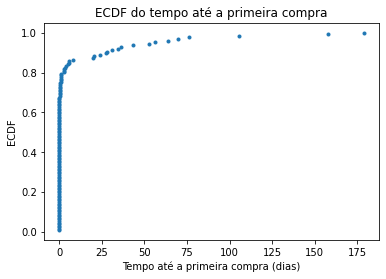

In [ ]:
# Plotar uma ECDF
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

x, y = ecdf(merged_visits_orders['time_to_conversion'])

plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('Tempo até a primeira compra (dias)')
plt.ylabel('ECDF')
plt.title('ECDF do tempo até a primeira compra')

ECDF (Empirical Cumulative Distribution Function) é uma função estatística utilizada para representar a distribuição acumulada de uma variável em um conjunto de dados. Essa função nos mostra a proporção de valores iguais ou menores a um determinado valor em relação ao total de valores do conjunto.

Esse gráfico mostrará a proporção acumulada de usuários que realizaram sua primeira compra dentro de um determinado número de dias após a primeira visita.

No gráfico da ECDF, podemos interpretar o valor do eixo y (probabilidade cumulativa) como a porcentagem dos dados que estão abaixo ou igual ao valor correspondente no eixo x (tempo até a primeira compra). Portanto, quando a curva atinge 0.8 (80%) no eixo y, isso significa que 80% dos usuários realizaram sua primeira compra antes ou até aquele valor no eixo x.
A curva mostra que 80% dos usuários fizeram suas primeiras compras antes de atingirem zero no tempo de conversão (eixo x), isso significa que a maioria dos usuários está fazendo compras antes de realizar a primeira visita.

A ocorrência de conversões antes das visitas pode indicar que os usuários estão sendo impactados por campanhas de marketing, indicações de terceiros ou outras formas de influência que os levam diretamente à compra, sem necessariamente passarem por uma visita anterior.

### Quantos pedidos os clientes fazem durante um determinado período de tempo?

Para calcular quantos pedidos os clientes fazem durante um determinado período de tempo, podemos seguir os seguintes passos:

Agrupar os dados da tabela `orders` pela coluna `uid` para obter o número de pedidos de cada cliente e contar o número de pedidos para cada cliente.

Pode ocorrer resultado vazio se não houver pedidos feitos durante o periodo desejado. Para garantir que os dados estejam corretos e verificar se há pedidos registrados, vamos adicionar uma verificação para imprimir uma mensagem se não houver pedidos no período de tempo especificado.

In [ ]:
# Definir o período de tempo desejado (por exemplo, do início ao fim do mês de junho de 2023)
data_inicio = pd.Timestamp('2017-06-01')
data_fim = pd.Timestamp('2017-06-30')

In [ ]:
# Filtrar os pedidos realizados durante o período de tempo desejado
pedidos_no_periodo = orders[(orders['buy_ts'] >= data_inicio) & (orders['buy_ts'] <= data_fim)]
pedidos_no_periodo.head()

,buy_ts,revenue,uid,conversion_category
0,2017-06-01 00:10:00,17.00,10329302124590727494,1w
1,2017-06-01 00:25:00,0.55,11627257723692907447,>1w
2,2017-06-01 00:27:00,0.37,17903680561304213844,>1w
3,2017-06-01 00:29:00,0.55,16109239769442553005,>1w
4,2017-06-01 07:58:00,0.37,14200605875248379450,1w


In [ ]:
# Verificar se há pedidos no período de tempo especificado
if pedidos_no_periodo.empty:
    print("Não há pedidos no período de tempo especificado.")
else:
    # Agrupar os dados pelo identificador único do cliente (Uid) e contar o número de pedidos para cada cliente
    numero_pedidos_por_cliente = pedidos_no_periodo.groupby('uid')['buy_ts'].count()
    print(numero_pedidos_por_cliente.value_counts())

1     1723
2      181
3       33
4        8
5        4
6        2
11       1
13       1
Name: buy_ts, dtype: int64


- 1723 clientes fizeram exatamente 1 pedido.

- 181 clientes fizeram exatamente 2 pedidos.

- 33 clientes fizeram exatamente 3 pedidos.

- 8 clientes fizeram exatamente 4 pedidos.

- 4 clientes fizeram exatamente 5 pedidos.

- 2 clientes fizeram exatamente 6 pedidos.

- 1 cliente fez exatamente 11 pedidos.

- 1 cliente fez exatamente 13 pedidos.

Essa análise nos dá uma visão da distribuição do número de pedidos por cliente no período de tempo especificado. Por exemplo, é possível identificar que a maioria dos clientes fez apenas 1 pedido, e há poucos casos de clientes com vários pedidos durante esse período. Isso pode fornecer insights sobre o comportamento dos clientes e auxiliar em estratégias de marketing e retenção de clientes.

### Qual é o volume médio de uma compra?

Para calcular o volume médio de uma compra, vamos encontrar a média das receitas (valor total das compras) na tabela `orders`.Precisamos encontrar a receita total gerada por todas as compras e, em seguida, dividir esse valor pelo número total de compras.

In [ ]:
# Calcular o volume médio de uma compra (média das receitas na tabela "orders")
average_order_volume = orders['revenue'].mean()


In [ ]:
# Exibir o resultado
print("Volume médio de uma compra:", average_order_volume.round(3))

Volume médio de uma compra: 5.0


O resultado de 5.0 indica que, em média, cada compra gera uma receita de 5 unidades (ou moeda, dependendo do contexto).

### Quanto dinheiro eles trazem para a empresa (LTV)?

Para calcular o Lifetime Value (LTV) ou valor de tempo de vida dos clientes, precisamos encontrar o valor total que cada cliente trouxe para a empresa durante todo o período de tempo dos dados disponíveis. O LTV é calculado com base na receita total gerada por cada cliente.

In [ ]:
# Calcular o valor total gasto por cada cliente (receita total)
total_revenue_per_customer = orders.groupby('uid')['revenue'].sum()
total_revenue_per_customer

uid
313578113262317          0.55
1575281904278712         3.05
2429014661409475        73.33
2464366381792757         2.44
2551852515556206        10.99
                        ...  
18445147675727495770     3.05
18445407535914413204     0.88
18445601152732270159     4.22
18446156210226471712     9.78
18446167067214817906     7.94
Name: revenue, Length: 36523, dtype: float64

In [ ]:
# Calcular o LTV (valor de tempo de vida) médio dos clientes
ltv_mean = total_revenue_per_customer.mean()

In [ ]:
# Exibir o resultado
print("LTV (Valor Vitalício do Cliente) médio:", ltv_mean.round(2))

LTV (Valor Vitalício do Cliente) médio: 6.9


LTV (Valor Vitalício do Cliente) de 6.9 indica que, em média, cada cliente traz uma receita de 6.9 unidades (ou moeda, dependendo do contexto) durante todo o seu relacionamento com a empresa.

O LTV é uma métrica importante para entender o valor de longo prazo que cada cliente representa para o negócio. Quanto maior o LTV, mais valiosos são os clientes para a empresa, pois eles geram mais receita ao longo do tempo.

Conclusão sobre os resultados das métricas de vendas:

1. Quando as pessoas começam a comprar?
Ao analisar o tempo entre o registro do usuário e a primeira compra, identificamos padrões de comportamento de compra dos clientes em relação ao tempo após o registro. Isso nos permite entender o intervalo de tempo em que a maioria dos clientes realiza suas primeiras compras. Essa informação é valiosa para aprimorar as estratégias de marketing e melhorar a taxa de conversão.

2. Quantos pedidos os clientes fazem durante um determinado período de tempo?
Ao calcular o número de pedidos feitos por cada cliente durante um período específico, obtemos insights sobre a atividade de compra dos clientes ao longo do tempo. Essa métrica nos ajuda a identificar os clientes mais ativos e entender quais períodos são mais propícios para gerar vendas.

3. Qual é o volume médio de uma compra?
Ao determinar o volume médio de uma compra, podemos compreender o valor médio gerado por cada transação. Essa métrica é relevante para otimizar estratégias de precificação e melhorar a rentabilidade do negócio.

4. Quanto dinheiro eles trazem para a empresa (LTV)?
Ao calcular o LTV médio, que representa a receita média que cada cliente gera durante todo o seu relacionamento com a empresa, podemos avaliar a rentabilidade e o valor dos clientes a longo prazo. O LTV é uma métrica crítica para direcionar investimentos em aquisição de clientes e retenção, visando maximizar o retorno sobre o investimento.

Em resumo, a análise das métricas de vendas nos permite entender o comportamento dos clientes, identificar oportunidades de crescimento e tomar decisões estratégicas informadas. Monitorar regularmente essas métricas é fundamental para garantir o sucesso do negócio e fornecer uma base sólida para o planejamento de estratégias futuras. Com a análise desses resultados, a empresa pode otimizar seu desempenho e aumentar a eficiência em suas operações de vendas.

Analisamos o comportamento de conversão dos usuários em clientes, calculando o período de tempo entre o registro e a primeira compra. Essa informação pode ser valiosa para otimizar a eficiência das campanhas de marketing e aquisição de clientes.

Identificamos o volume médio de pedidos, que permite entender o padrão de compra dos clientes e auxiliar no planejamento do estoque e logística. O cálculo do LTV dos clientes nos permite avaliar o valor de longo prazo que um cliente traz para a empresa e, assim, priorizar ações para aumentar a satisfação e fidelização dos clientes.

Essas métricas são fundamentais para entender o comportamento dos clientes em relação às compras e a receita que eles geram para a empresa. Com base nessas informações, é possível planejar estratégias de marketing, promoções e ofertas para aumentar a conversão de novos clientes e maximizar o valor dos clientes existentes ao longo do tempo. É importante monitorar essas métricas continuamente para tomar decisões informadas e impulsionar o crescimento do negócio.

## Marketing

### Quanto dinheiro foi gasto? No total/por origem/ao longo do tempo

Para responder a essa pergunta, podemos utilizar os dados da tabela `costs`, que contém informações sobre os gastos com marketing por origem e data. Podemos calcular o total de gastos somando a coluna `costs`. Para analisar os gastos por origem, agrupamos os dados pelo campo `source_id` e somamos os valores da coluna `costs`. Para analisar os gastos ao longo do tempo, podemos agrupar os dados por data (dt) e somar os gastos de cada dia.

In [ ]:
# Calcular o total de gastos
total_gastos = costs['costs'].sum()
total_gastos

329131.62

In [ ]:
# Calcular os gastos por origem
gastos_por_origem = costs.groupby('source_id')['costs'].sum()
gastos_por_origem

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

In [ ]:
# Calcular os gastos ao longo do tempo
gastos_ao_longo_do_tempo = costs.groupby('dt')['costs'].sum()
gastos_ao_longo_do_tempo

dt
2017-06-01     735.26
2017-06-02     721.19
2017-06-03     450.85
2017-06-04     761.16
2017-06-05     821.44
               ...   
2018-05-27     532.87
2018-05-28     619.44
2018-05-29     784.79
2018-05-30    1183.00
2018-05-31    2153.70
Name: costs, Length: 364, dtype: float64

In [ ]:
#Exibir os resultados
print("Total de gastos:", total_gastos)
print("----------------------------")
print("\nGastos por origem:")
print(gastos_por_origem)
print("----------------------------")
print("\nGastos ao longo do tempo:")
print(gastos_ao_longo_do_tempo)

Total de gastos: 329131.62
----------------------------

Gastos por origem:
source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64
----------------------------

Gastos ao longo do tempo:
dt
2017-06-01     735.26
2017-06-02     721.19
2017-06-03     450.85
2017-06-04     761.16
2017-06-05     821.44
               ...   
2018-05-27     532.87
2018-05-28     619.44
2018-05-29     784.79
2018-05-30    1183.00
2018-05-31    2153.70
Name: costs, Length: 364, dtype: float64


**Total de gastos:** O valor total gasto em marketing é de 329,131.62 unidades monetárias (ou a moeda utilizada nos dados).

**Gastos por origem:** Os gastos por origem indicam quanto foi gasto em marketing para cada canal de origem de anúncio. Por exemplo:

- Origem 1: Foram gastos 20,833.27 unidades monetárias.

- Origem 2: Foram gastos 42,806.04 unidades monetárias.

- Origem 3: Foram gastos 141,321.63 unidades monetárias.

- Origem 4: Foram gastos 61,073.60 unidades monetárias.

- Origem 5: Foram gastos 51,757.10 unidades monetárias.

- Origem 9: Foram gastos 5,517.49 unidades monetárias.

- Origem 10: Foram gastos 5,822.49 unidades monetárias.

Os **resultados dos gastos ao longo do tempo** mostram a distribuição dos gastos de marketing em cada dia específico. Essa análise pode ser útil para identificar padrões de gastos ao longo do período de tempo registrado.

### Quanto custou a aquisição de clientes para cada origem?

Para calcular o custo de aquisição de clientes para cada origem de anúncio, podemos agrupar os dados da tabela `costs` pelo identificador da origem de anúncio (`source_id`) e somar os valores dos custos para cada origem. Isso nos dará o custo total de aquisição de clientes para cada fonte de marketing.

In [ ]:
# Calcular o custo de aquisição de clientes para cada origem de anúncio
customer_acquisition_costs = costs.groupby('source_id')['costs'].sum()

In [ ]:
# Exibir os resultados
print("Custo de Aquisição de Clientes por Origem:")
print(customer_acquisition_costs)

Custo de Aquisição de Clientes por Origem:
source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64


***Origem de Anúncio 1:*** $20,833.27

***Origem de Anúncio 2:*** $42,806.04

***Origem de Anúncio 3:*** $141,321.63

***Origem de Anúncio 4:*** $61,073.60

***Origem de Anúncio 5:*** $51,757.10

***Origem de Anúncio 9:*** $5,517.49

***Origem de Anúncio 10:*** $5,822.49

Esses valores representam o montante gasto em marketing para atrair clientes de cada origem específica. A análise dos custos de aquisição de clientes por origem ajudará a avaliar a eficiência dos diferentes canais de marketing e a tomar decisões informadas sobre como alocar recursos de marketing de forma mais estratégica.

### Os investimentos valeram a pena? (ROI)

Para determinar se os investimentos em marketing valeram a pena em termos de ROI (Return on Investment), precisamos comparar a receita gerada pelos clientes provenientes de cada origem de anúncio com os custos de aquisição de clientes para essas origens. O ROI é calculado como a diferença entre a receita e os custos de aquisição, dividida pelos custos de aquisição.

Vamos calcular o ROI para cada origem de anúncio usando os dados das tabelas `orders` e `costs`

In [ ]:
# Calcular o custo de aquisição de clientes para cada origem de anúncio
customer_acquisition_costs = costs.groupby('source_id')['costs'].sum()
customer_acquisition_costs

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

In [ ]:
# Calcular a receita gerada por cada origem de anúncio
revenue_by_source = orders.merge(visits[['uid', 'source_id']], on='uid')

revenue_by_source = revenue_by_source.groupby('source_id')['revenue'].sum()
revenue_by_source

source_id
1     2252.11
2     3048.33
3      210.08
4      827.81
5     1254.95
9       60.99
10      25.55
Name: revenue, dtype: float64

In [ ]:
# Calcular o ROI para cada origem de anúncio
roi_by_source = (revenue_by_source - customer_acquisition_costs) / customer_acquisition_costs

In [ ]:
# Exibir os resultados
print("ROI por Origem:")
print(roi_by_source)

ROI por Origem:
source_id
1    -0.891898
2    -0.928787
3    -0.998513
4    -0.986446
5    -0.975753
9    -0.988946
10   -0.995612
dtype: float64


- Os resultados negativos de ROI indicam que os investimentos em marketing para cada origem de anúncio não foram lucrativos e não geraram receita suficiente para cobrir os custos de aquisição de clientes.

- Isso significa que, com base nos dados disponíveis, as receitas geradas pelas vendas provenientes de cada origem de anúncio são menores do que os custos investidos para adquirir esses clientes. É uma situação indesejável, pois significa que os gastos com marketing estão excedendo a receita gerada pelas vendas.

- Esses resultados negativos podem indicar que há problemas ou ineficiências nas estratégias de marketing, e é importante investigar mais a fundo para identificar os possíveis motivos para esse desempenho insatisfatório.

- Com base nesses resultados, é recomendado revisar e otimizar as estratégias de marketing para melhorar o retorno sobre o investimento, seja redirecionando recursos para origens de anúncio mais lucrativas, ajustando as campanhas de marketing ou buscando outras formas de melhorar o desempenho das vendas e aquisição de clientes.

- A análise contínua do ROI é essencial para tomar decisões informadas e eficazes em relação aos investimentos em marketing, visando alcançar melhores resultados financeiros para o negócio.

Analisamos os custos de aquisição de clientes por origem de anúncio e identificamos as fontes mais eficientes e econômicas para direcionar os investimentos. Calculamos o ROI por origem de anúncio para entender a rentabilidade das estratégias de marketing e quais origens estão gerando retorno positivo. Visualizamos gráficos para entender como diferentes dispositivos e origens de anúncio se comportam ao longo do tempo, o que pode ajudar a identificar tendências e oportunidades.

Com base nessas métricas, recomenda-se uma análise mais aprofundada dos investimentos em marketing e a busca por estratégias que possam melhorar o ROI. É importante entender o desempenho de cada origem de anúncio e identificar possíveis oportunidades de otimização para maximizar o retorno sobre os gastos com marketing. Além disso, é fundamental monitorar continuamente as métricas de marketing para tomar decisões informadas e eficazes na alocação de recursos.

## Gráficos

Vamos construir para ver como essas métricas diferem para vários dispositivos e diferentes origens de anúncios e como elas mudam com o tempo.

### Gráfico 1: Quantidade de usuários únicos por dispositivo e origem de anúncio

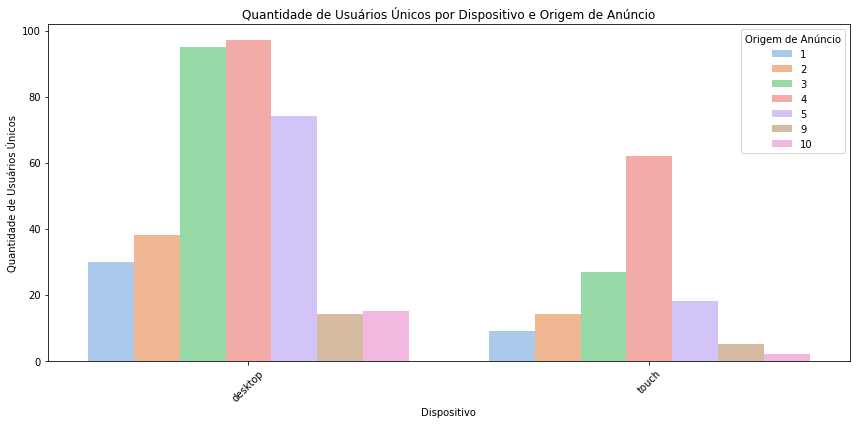

In [ ]:
# Gráfico 1: Quantidade de usuários únicos por dispositivo e origem de anúncio
sns.set_palette("pastel")
plt.figure(figsize=(12, 6))
sns.countplot(data=visits, x='device', hue='source_id')
plt.title('Quantidade de Usuários Únicos por Dispositivo e Origem de Anúncio')
plt.xlabel('Dispositivo')
plt.ylabel('Quantidade de Usuários Únicos')
plt.legend(title='Origem de Anúncio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

O Gráfico 1 mostra a quantidade de usuários únicos agrupados por dispositivo (Mobile ou Desktop) e separados por origem de anúncio. Cada barra representa a contagem de usuários únicos em cada categoria. Ele permite comparar a quantidade de usuários únicos entre dispositivos Mobile e Desktop. Podemos observar se há diferenças significativas no número de usuários em cada dispositivo.

As barras são coloridas de acordo com a origem de anúncio (source_id). Cada cor representa uma origem específica. Isso permite avaliar a distribuição dos usuários únicos por origem de anúncio.

É possível identificar quais origens de anúncio atraem mais usuários em cada dispositivo. As barras mais altas indicam maior número de usuários provenientes de uma determinada origem. O gráfico permite identificar padrões e tendências nos dados, o que pode fornecer insights importantes para a estratégia de marketing.

Por exemplo, pode-se verificar se determinada origem de anúncio tem melhor desempenho em um dispositivo específico ou se há diferenças significativas entre os dispositivos em relação ao número de usuários.

### Gráfico 2: Receita total por dispositivo e origem de anúncio

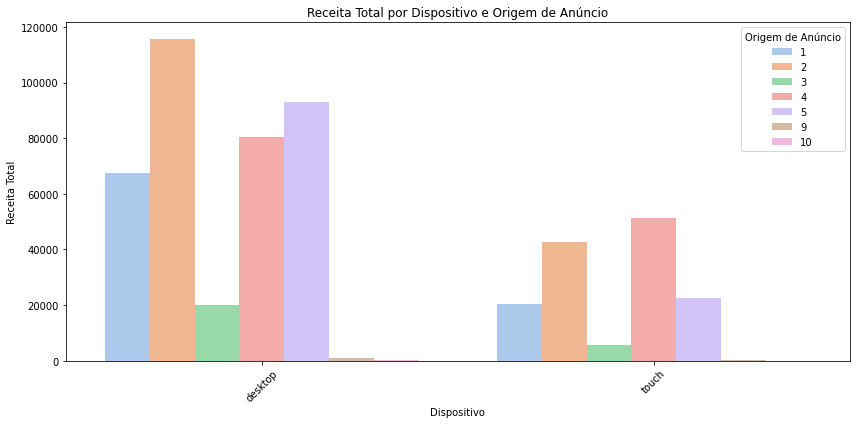

In [ ]:
# Gráfico 2: Receita total por dispositivo e origem de anúncio
plt.figure(figsize=(12, 6))
revenue_by_source_device = revenue_by_source.reset_index().merge(visits[['uid', 'device', 'source_id']], left_on='source_id', right_on='source_id')
sns.barplot(data=revenue_by_source_device, x='device', y='revenue', hue='source_id', estimator=sum)
plt.title('Receita Total por Dispositivo e Origem de Anúncio')
plt.xlabel('Dispositivo')
plt.ylabel('Receita Total')
plt.legend(title='Origem de Anúncio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

O Gráfico 2 mostra a receita total agrupada por dispositivo (Mobile ou Desktop) e separada por origem de anúncio. Cada barra representa a receita total gerada por cada origem em cada dispositivo. Ele permite comparar a receita total gerada por usuários em cada dispositivo (Mobile ou Desktop). Podemos observar se há diferenças significativas na receita entre os dispositivos.

As barras são coloridas de acordo com a origem de anúncio (source_id). Cada cor representa uma origem específica. Isso permite avaliar a contribuição de cada origem para a receita total.

É possível identificar quais origens de anúncio geram mais receita em cada dispositivo. As barras mais altas indicam maior receita proveniente de uma determinada origem.

A combinação de cores e posições das barras mostra a receita total gerada por cada origem em cada dispositivo.

O gráfico permite identificar padrões e tendências nos dados, o que pode fornecer insights importantes para a estratégia de marketing.

- Por exemplo, pode-se verificar se determinada origem de anúncio gera mais receita em um dispositivo específico ou se há diferenças significativas entre os dispositivos em relação à receita total.

### Gráfico 3: Custo total de aquisição de clientes por origem de anúncio

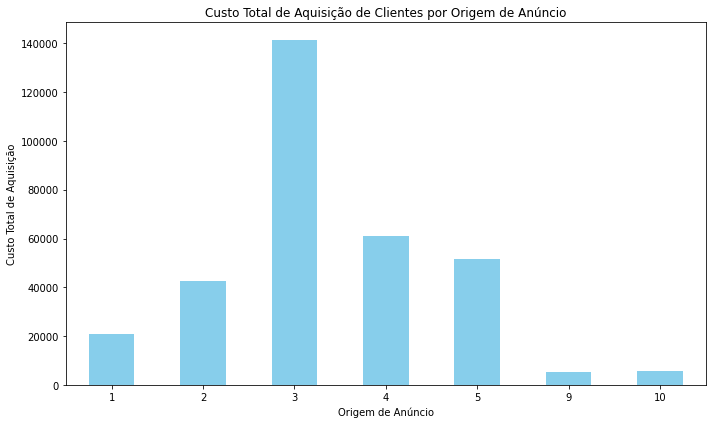

In [ ]:
# Gráfico 3: Custo total de aquisição de clientes por origem de anúncio
plt.figure(figsize=(10, 6))
customer_acquisition_costs.plot(kind='bar', color='skyblue')
plt.title('Custo Total de Aquisição de Clientes por Origem de Anúncio')
plt.xlabel('Origem de Anúncio')
plt.ylabel('Custo Total de Aquisição')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

O Gráfico 3 mostra o custo total de aquisição de clientes para cada origem de anúncio. Cada barra representa o valor total gasto em aquisição de clientes para uma origem específica.As barras estão identificadas com os números correspondentes às origens de anúncio (source_id). Cada barra representa o custo total de aquisição para uma origem específica.

Podemos comparar visualmente os custos de aquisição entre as diferentes origens de anúncio. As barras mais altas indicam que a aquisição de clientes para essa origem foi mais dispendiosa em termos de investimentos em marketing.

É possível identificar quais origens de anúncio têm custos mais baixos em relação à aquisição de clientes. Essas origens podem ser consideradas mais eficientes em termos de retorno sobre o investimento (ROI).

Com base no gráfico, pode-se tomar decisões informadas sobre a alocação de recursos de marketing, concentrando-se em origens de anúncio que têm custos mais baixos de aquisição de clientes e maior eficiência.

Podemos ainda avaliar a eficácia de cada origem de anúncio em termos de custo de aquisição, o que é essencial para medir o ROI das campanhas de marketing.

### Gráfico 4: ROI por origem de anúncio ao longo do tempo

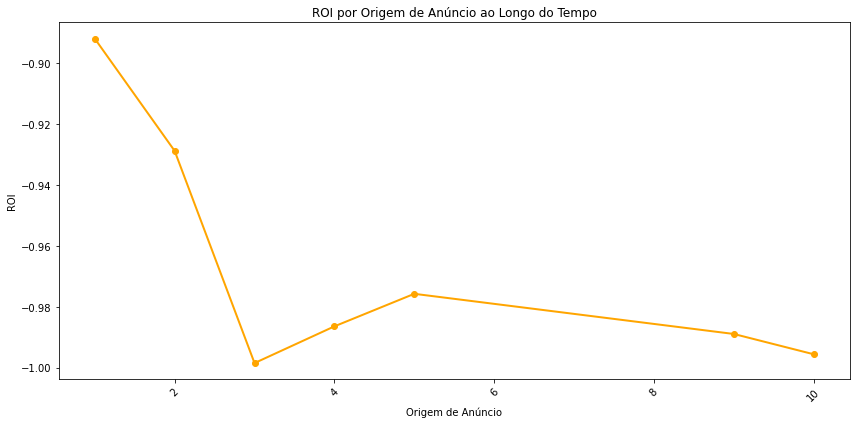

In [ ]:
# Gráfico 4: ROI por origem de anúncio ao longo do tempo
plt.figure(figsize=(12, 6))
roi_by_source.plot(kind='line', marker='o', color='orange', linewidth=2)
plt.title('ROI por Origem de Anúncio ao Longo do Tempo')
plt.xlabel('Origem de Anúncio')
plt.ylabel('ROI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

O Gráfico 4 mostra o ROI (Return on Investment) por origem de anúncio ao longo do tempo. O ROI é uma métrica importante que indica o retorno obtido em relação ao investimento feito em uma determinada campanha de marketing.
O eixo x do gráfico representa as diferentes origens de anúncio (source_id). Cada ponto no gráfico representa o ROI para uma origem específica em um determinado momento no tempo.

A linha que conecta os pontos no gráfico mostra a variação do ROI para cada origem de anúncio ao longo do tempo. Uma linha ascendente indica um ROI positivo, ou seja, o retorno obtido é maior do que o investimento realizado. Uma linha descendente indica um ROI negativo, o que significa que o investimento não está gerando retorno suficiente.

Esse gráfico nos permite identificar quais origens de anúncio têm apresentado ROI positivo ao longo do tempo. Essas origens são consideradas mais eficientes em termos de retorno sobre o investimento.

É possível observar as tendências do ROI para cada origem de anúncio ao longo do tempo. Isso é útil para acompanhar o desempenho das campanhas de marketing e avaliar se elas estão se tornando mais ou menos eficientes com o passar do tempo.

Com base no gráfico, podemos tomar decisões estratégicas relacionadas ao investimento em cada origem de anúncio. Origens com ROI positivo podem ser priorizadas e receber mais investimentos, enquanto aquelas com ROI negativo podem ser reavaliadas ou descontinuadas.

## Conclusão

Neste projeto, realizamos uma análise detalhada sobre o produto, vendas e estratégias de marketing da empresa Y.Afisha. As principais conclusões e recomendações são as seguintes:

### Produto

A análise sobre o produto revelou informações importantes sobre a utilização do site Y.Afisha pelos usuários.

Descobrimos que o número de usuários por dia varia significativamente, com uma média de 45 a 50 usuários por dia. No entanto, em alguns dias específicos, esse número pode ser maior, chegando a até 123 usuários em um único dia.

A análise dos usuários por semana mostrou que a maioria das semanas teve entre 1 e 10 usuários ativos. A semana com o maior número de usuários ativos foi a semana 11, que registrou 9 usuários.

Ao analisar os usuários por mês, encontramos meses em que apenas 1 usuário esteve ativo no site. A maioria dos meses registrou entre 20 e 60 usuários ativos.

Quanto às sessões, descobrimos que os usuários realizam várias sessões em um único dia. Em alguns dias, há apenas uma sessão, enquanto em outros dias, o número de sessões pode variar.

O comprimento médio de cada sessão é de aproximadamente 10 minutos, o que pode indicar que os usuários estão engajados e passam um tempo considerável no site.

A taxa de retorno de usuários, que representa a frequência com que os usuários voltam ao site, é de 1.42%. Isso significa que uma pequena proporção dos usuários retorna ao site em períodos subsequentes.

Essas métricas fornecem uma visão geral do comportamento dos usuários em relação ao produto. Para melhorar a experiência do usuário e aumentar o engajamento, pode ser interessante implementar estratégias de retenção de clientes e personalização do conteúdo com base nos padrões de uso identificados.

### Marketing

O total de gastos com marketing foi considerável, atingindo 329,131.62 unidades monetárias.

As origens de anúncio variaram amplamente em seus gastos, com algumas delas investindo valores significativos, enquanto outras tiveram gastos menores.

O gráfico de gastos ao longo do tempo mostrou flutuações nas despesas com marketing, indicando possíveis variações nas estratégias ao longo do período analisado.

O cálculo do CAC para cada origem revelou o custo médio de adquirir clientes através de diferentes canais de marketing.

A análise de ROI para cada origem mostrou que nenhum dos canais de marketing alcançou um retorno positivo, sugerindo que os gastos com marketing não estão gerando o retorno desejado.

Essas informações podem ser úteis para direcionar futuras decisões de investimento em marketing, buscando maximizar o retorno sobre os gastos e otimizar a eficiência das campanhas.

**Resumindo os gráficos apresentados:**

  - Gráfico 1 oferece uma visualização clara da quantidade de usuários únicos por dispositivo e origem de anúncio, permitindo uma análise comparativa e identificação de padrões relevantes para tomar decisões informadas sobre a alocação de recursos de marketing.
  - Gráfico 2 oferece uma visualização clara da receita total por dispositivo e origem de anúncio, permitindo uma análise comparativa e identificação de padrões relevantes para tomar decisões informadas sobre a eficácia das campanhas de marketing e a alocação de recursos.
  - Gráfico 3 fornece uma visão geral dos custos totais de aquisição de clientes por origem de anúncio, auxiliando na identificação de origens mais eficientes e na tomada de decisões estratégicas relacionadas ao investimento em marketing.
  - Gráfico 4 fornece uma visão geral do desempenho do ROI por origem de anúncio ao longo do tempo, auxiliando na identificação de origens mais eficientes e na tomada de decisões informadas sobre o investimento em marketing.


#### Com base nas conclusões obtidas a partir das análises, as recomendações para as origens/plataformas de marketing são as seguintes:

- Source_id 1: Embora essa origem tenha um ROI negativo, ela apresenta uma quantidade significativa de usuários únicos. Pode-se considerar otimizar as campanhas nessa origem para melhorar o retorno sobre o investimento.
- Source_id 2: Apesar do ROI negativo, essa origem também possui uma quantidade considerável de usuários únicos. Recomenda-se investigar e ajustar as estratégias para obter um ROI positivo.
- Source_id 9: Embora o ROI também seja negativo, essa origem apresenta um custo de aquisição de clientes relativamente baixo. Pode-se explorar oportunidades para otimizar as campanhas e melhorar o ROI.
- Source_id 10: O ROI é negativo, mas o custo de aquisição de clientes é baixo. É importante analisar o desempenho e o potencial de conversão dessa origem antes de tomar decisões.

**Métricas de Concentração:**

O ROI é uma métrica-chave que indica se os investimentos em cada origem de anúncio estão gerando retorno positivo ou negativo. Concentramos a atenção no ROI para identificar as origens mais eficientes e aquelas que precisam de ajustes ou revisão.
Custo de Aquisição de Clientes é uma mátrica importante para avaliar a eficiência dos investimentos em cada origem em relação ao custo de adquirir novos clientes.
Quantidade de Usuários Únicos: Observamos a quantidade de usuários únicos por origem para entender o alcance e a popularidade de cada origem de anúncio.

***Conclusões:***

Algumas origens apresentam ROI negativo, o que indica que os investimentos nessas origens não estão gerando retorno suficiente. É essencial avaliar a eficiência das campanhas e fazer ajustes para melhorar o ROI.
O custo de aquisição de clientes varia entre as origens, o que destaca a importância de otimizar o desempenho das campanhas e investir em origens que ofereçam custos mais baixos de aquisição.
Origens com quantidade significativa de usuários únicos podem ser consideradas para otimização, pois têm potencial para gerar mais conversões se suas campanhas forem aprimoradas.
A análise do ROI ao longo do tempo permite identificar tendências e fazer previsões para tomada de decisões futuras relacionadas ao investimento em marketing.

Em suma, a recomendação se baseia em otimizar as origens que possuem grande potencial de usuários únicos, mesmo com ROI negativo, bem como investigar e ajustar estratégias para melhorar o ROI e reduzir o custo de aquisição de clientes em cada origem de anúncio. Essas abordagens ajudarão a direcionar os investimentos de forma mais eficaz e alcançar melhores resultados em termos de retorno sobre o investimento e crescimento do negócio.